In [1]:
import json, os, sys, random, re
sys.path.append("../scripts/formalism")
from entropy import *
from utils import *
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from pprint import pprint
from textblob import Word
import matplotlib.pyplot as plt

In [19]:
files = [
    "../data/nocaps/tmp.json",
    "../data/vl_models_are_bows/tmp.json",
]

annotations = defaultdict(list)
for f in files:
    J = json.load(open(f, "r"))
    for r in J:
        annotations[r].extend(J[r])
for r in annotations:
    print(r, len(annotations[r]))
print(f"Aggregated #instances = {sum([len(annotations[r]) for r in annotations])}")

in front of 2048
on 13369
above 435
on top of 755
under 401
behind 968
below 239
beneath 18
at the bottom of 14
to the right of 7743
to the left of 7742
Aggregated #instances = 33732


In [24]:
positional_rel_v = ["below", "beneath", "under", "at the bottom of", "above", "on top of", "on"]
positional_rel_h = ["to the left of", "to the right of"]
positional_rel_fb = ["in front of", "behind"]

entropy_funcs = [
    "concept_centric_entropy3(num_nouns, num_relations, df)",
    "concept_centric_entropy4(num_nouns, num_relations, df)",
    "concept_centric_entropy5(num_nouns, num_relations, df)",
    "relation_centric_entropy3(num_nouns, num_relations, df)",
    "relation_centric_entropy4(num_nouns, num_relations, df)",
    "relation_centric_entropy5(num_nouns, num_relations, df)",
    "divergence(num_nouns, num_relations, df)",
    "divergence2(num_nouns, num_relations, df)",
    "divergence3(num_nouns, num_relations, df)",
    "concept_role_entropy(num_nouns, df)",
    "concept_role_entropy2(num_nouns, df)",
    "role_association(num_nouns, df)",
    "role_association2(num_nouns, df)",
    "concept_entropy(num_nouns, df)",
    "concept_entropy2(num_nouns, df)",
    "concept_entropy0(num_nouns, df)",
    "concept_role_index_entropy(num_nouns, df)"
]

### Top-Bottom (merged)

In [108]:
map = {
    "above": "top",
    "on": "top", 
    "on top of": "top", 
    "at the bottom of": "bottom",
    "below": "bottom", 
    "beneath": "bottom",
    "under": "bottom"
}
relations = ["top", "bottom"]

In [109]:
heatmap = {}

# get tuples
SUBJ, OBJ = [], []
tuples = []
for unmapped_r in annotations:
    if not unmapped_r in positional_rel_v: continue
    r = map[unmapped_r]

    for a in annotations[unmapped_r]:
        subj, obj, _ = a[1]
        #singularize
        singlular_subj = Word(subj).lemmatize()
        if not singlular_subj == False: subj = singlular_subj
        singlular_obj = Word(obj).lemmatize() 
        if not singlular_obj == False: obj = singlular_obj

        SUBJ.append(subj)
        OBJ.append(obj)
        tuples.append((subj, obj, r))

print("#unique subjects = ", len(set(SUBJ)))
print("#unique objects = ", len(set(OBJ)))
nouns = sorted(list(set(SUBJ).union(set(OBJ))))
num_nouns = len(nouns)
print("#unique concepts = ", num_nouns)
num_relations = len(relations)
print("#instances = ", len(tuples))

train_triplets = [] # convert tuple elements to indices
n2i = {n:i for i, n in enumerate(nouns)}
r2i = {r:i for i, r in enumerate(relations)}
print(len(r2i), len(n2i))


for transpose in [False, True]:
    train_triplets = []
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)
    c = Counter(train_triplets)
    
    prefix = "image" if transpose else "linguistic"
    heatmap[prefix] = np.zeros((num_nouns, num_nouns))
    X = []
    for k, o1 in enumerate(nouns):
        for l, o2 in enumerate(nouns):
            x = c[(n2i[o1], n2i[o2], 0)] + c[(n2i[o1], n2i[o2], 1)]
            X.append(x)
            heatmap[prefix][k][l] = x


#unique subjects =  1854
#unique objects =  1136
#unique concepts =  2364
#instances =  15231
2 2364


In [110]:
dead = []
iters = 0
killed_this_iter = True
while np.sum(heatmap['image']) * np.sum(heatmap['linguistic']) > 0 and killed_this_iter:
    killed_this_iter = False
    sum_axis0, sum_axis1 = np.sum(heatmap['image'], axis=0), np.sum(heatmap['image'], axis=1)
    for i, s in enumerate(sum_axis0):
        if i in dead: continue
        if s == 0:
            for j in range(len(nouns)):
                # drop row i
                heatmap['image'][i][j] = 0
                # drop row i and col i
                heatmap['linguistic'][i][j] = 0
                heatmap['linguistic'][j][i] = 0

            dead.append(i)
            killed_this_iter = True
    for i, s in enumerate(sum_axis1):
        if i in dead: continue
        if s == 0:
            for j in range(len(nouns)):
                # drop col i
                heatmap['image'][j][i] = 0
                # drop row i and col i
                heatmap['linguistic'][i][j] = 0
                heatmap['linguistic'][j][i] = 0
            dead.append(i)
            killed_this_iter = True

    sum_axis0, sum_axis1 = np.sum(heatmap['linguistic'], axis=0), np.sum(heatmap['linguistic'], axis=1)
    for i, s in enumerate(sum_axis0):
        if i in dead: continue
        if s == 0:
            for j in range(len(nouns)):
                # drop row i
                heatmap['linguistic'][i][j] = 0
                # drop row i and col i
                heatmap['image'][i][j] = 0
                heatmap['image'][j][i] = 0

            dead.append(i)
            killed_this_iter = True
    for i, s in enumerate(sum_axis1):
        if i in dead: continue
        if s == 0:
            for j in range(len(nouns)):
                # drop col i
                heatmap['linguistic'][j][i] = 0
                # drop row i and col i
                heatmap['image'][i][j] = 0
                heatmap['image'][j][i] = 0
            dead.append(i)
            killed_this_iter = True

    iters += 1
    print(f"dead nouns = {len(dead)}")
    print(f"""finish iter {iters}, 
          remaining examples = {np.sum(heatmap['image'])} (image), 
          {np.sum(heatmap['linguistic'])} (linguistic)""")    


dead nouns = 1885
finish iter 1, 
          remaining examples = 7997.0 (image), 
          7997.0 (linguistic)
dead nouns = 1929
finish iter 2, 
          remaining examples = 7416.0 (image), 
          7416.0 (linguistic)
dead nouns = 1930
finish iter 3, 
          remaining examples = 7413.0 (image), 
          7413.0 (linguistic)
dead nouns = 1930
finish iter 4, 
          remaining examples = 7413.0 (image), 
          7413.0 (linguistic)


In [111]:
alive = set(list(range(len(nouns)))) - set(dead)
alive = sorted(list(alive))
print("nouns with complete support".format(alive))
print(len(alive))
rows = np.array(alive, dtype=np.intp)
columns = np.array(alive, dtype=np.intp)

bijective_heatmap = heatmap['linguistic'][np.ix_(rows, columns)]
print("sanity check (linguistic): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))

bijective_heatmap = heatmap['image'][np.ix_(rows, columns)]
print("sanity check (image): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))

crux = alive # They are both_complete_nouns' indices
print(len(crux))
crux_nouns = [nouns[i] for i in crux]
#pprint(crux_nouns)

nouns with complete support
434
sanity check (linguistic): every row sum or col sum is positive
1.0 1.0
sanity check (image): every row sum or col sum is positive
1.0 1.0
434


In [115]:
for transpose in [False, False]:
    print("role intrinsic meanings: {} position\n".format("image" if transpose else "linguistic"))
    SUBJ, OBJ = [], []
    tuples = []
    for unmapped_r in annotations:
        if not unmapped_r in positional_rel_v: continue
        
        r = map[unmapped_r]

        for a in annotations[unmapped_r]:
            subj, obj, _ = a[1]
            #singularize
            singlular_subj = Word(subj).lemmatize()
            if not singlular_subj == False: subj = singlular_subj
            singlular_obj = Word(obj).lemmatize() 
            if not singlular_obj == False: obj = singlular_obj

            if subj in crux_nouns and obj in crux_nouns:
                
                SUBJ.append(subj)
                OBJ.append(obj)
                tuples.append((subj, obj, r))
    
    nouns = sorted(list(set(SUBJ).union(set(OBJ))))
    num_nouns = len(nouns)
    print("#unique concepts = ", num_nouns)
    num_relations = len(relations)
    print("#instances = ", len(tuples))
    
    train_triplets = [] # convert tuple elements to indices
    n2i = {n:i for i, n in enumerate(nouns)}
    r2i = {r:i for i, r in enumerate(relations)}
    print(len(r2i), len(n2i), "\n")
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)

    # Sanity check crux_nouns are indeed complete under both linguistic & image positional roles
    print("#unique O1 = ", len(set([t[0] for t in train_triplets])))
    print("#unique O2 = ", len(set([t[1] for t in train_triplets])))
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    #for f in entropy_funcs:
        #score = eval(f)
        #print(f.split("(")[0], ": ", score) 
    print("--------------------------------------------------------\n\n")

role intrinsic meanings: linguistic position

['A roulette table and chairs under a portrait of a woman.', ['table', 'woman', 'under']]
('table', 'woman', 'bottom')
#unique concepts =  434
#instances =  7413
2 434 

#unique O1 =  434
#unique O2 =  434
--------------------------------------------------------


role intrinsic meanings: linguistic position

['A roulette table and chairs under a portrait of a woman.', ['table', 'woman', 'under']]
('table', 'woman', 'bottom')
#unique concepts =  434
#instances =  7413
2 434 

#unique O1 =  434
#unique O2 =  434
--------------------------------------------------------




In [116]:
if transpose:
    print(len(train_triplets))
    print("train_triplets under {} positional roles:".format("image" if transpose else "linguistic"))
    print(train_triplets)
    print("unique train_triplets = {}".format(len(set(train_triplets))))
print("diagonal supports: ", set([nouns[t[0]] for t in train_triplets if t[0] == t[1]]))

diagonal supports:  {'grill', 'sandwich', 'drum', 'couch', 'unit', 'lemon', 'kangaroo', 'pool', 'lobster', 'basket', 'street', 'pot', 'table', 'priest', 'water', 'chair', 'phone', 'sign', 'computer', 'structure', 'shelf', 'sink', 'brownie', 'woman', 'dog', 'bed', 'tool', 'room', 'car', 'shirt', 'motorcycle', 'layer', 'plate', 'ladybug', 'section', 'blade', 'tier', 'burner', 'ceiling', 'river', 'vegetable', 'pole'}


##### Save aggregated complete set based on crux_nouns

In [117]:
aggregated_data = []

In [118]:
annotations = json.load(open("../data/vl_models_are_bows/visual_genome_relation.json", "r"))
symmetric = ['adjusting', 'attached to', 'between', 'bigger than', 'biting', 'boarding', 'brushing', 'chewing', 'cleaning', 'climbing', 'close to', 'coming from', 'coming out of', 'contain', 'crossing', 'dragging', 'draped over', 'drinking', 'drinking from', 'driving', 'driving down', 'driving on', 'eating from', 'eating in', 'enclosing', 'exiting', 'facing', 'filled with', 'floating in', 'floating on', 'flying', 'flying above', 'flying in', 'flying over', 'flying through', 'full of', 'going down', 'going into', 'going through', 'grazing in', 'growing in', 'growing on', 'guiding', 'hanging from', 'hanging in', 'hanging off', 'hanging over', 'higher than', 'holding onto', 'hugging', 'in between', 'jumping off', 'jumping on', 'jumping over', 'kept in', 'larger than', 'leading', 'leaning over', 'leaving', 'licking', 'longer than', 'looking in', 'looking into', 'looking out', 'looking over', 'looking through', 'lying next to', 'lying on top of', 'making', 'mixed with', 'mounted on', 'moving', 'on the back of', 'on the edge of', 'on the front of', 'on the other side of', 'opening', 'painted on', 'parked at', 'parked beside', 'parked by', 'parked in', 'parked in front of', 'parked near', 'parked next to', 'perched on', 'petting', 'piled on', 'playing', 'playing in', 'playing on', 'playing with', 'pouring', 'reaching for', 'reading', 'reflected on', 'riding on', 'running in', 'running on', 'running through', 'seen through', 'sitting behind', 'sitting beside', 'sitting by', 'sitting in front of', 'sitting near', 'sitting next to', 'sitting under', 'skiing down', 'skiing on', 'sleeping in', 'sleeping on', 'smiling at', 'sniffing', 'splashing', 'sprinkled on', 'stacked on', 'standing against', 'standing around', 'standing behind', 'standing beside', 'standing in front of', 'standing near', 'standing next to', 'staring at', 'stuck in', 'surrounding', 'swimming in', 'swinging', 'talking to', 'topped with', 'touching', 'traveling down', 'traveling on', 'tying', 'typing on', 'underneath', 'wading in', 'waiting for', 'walking across', 'walking by', 'walking down', 'walking next to', 'walking through', 'working in', 'working on', 'worn on', 'wrapped around', 'wrapped in', 'by', 'of', 'near', 'next to', 'with', 'beside', 'on the side of', 'around']
annotations = [x for x in annotations if not x['relation_name'] in symmetric]

imdir = "vl_models_are_bows/images/{}"

for a in tqdm(annotations):
    r = a['relation_name']
    if not r in positional_rel_v: continue
    subj, obj = re.findall(rf'the ([a-zA-Z\s-]+) is {r} the ([a-zA-Z\s]+)', a['true_caption'])[0]
    
    #singularized subj & obj should belong to crux_nouns
    singlular_subj = Word(subj).lemmatize()
    if singlular_subj == False: singlular_subj = subj
    singlular_obj = Word(obj).lemmatize() 
    if singlular_obj == False: singlular_obj = obj
    
    if singlular_subj in crux_nouns and singlular_obj in crux_nouns:
        image_filename = imdir.format(a['image_path'])
        aggregated_data.append([
            a['true_caption'], 
            image_filename, 
            (singlular_subj, singlular_obj, map[r]),
            #(subj, obj, r)
        ])

print(len(aggregated_data))

100%|██████████| 21944/21944 [00:00<00:00, 563696.54it/s]

1758


In [119]:
imdir = "nocaps/images/{}"
J = json.load(open("../data/nocaps/nocaps_val_4500_captions.json", "r"))
annotations, image_info = J['annotations'], J['images']

for a in tqdm(annotations):
    for r in positional_rel_v:
        if f" {r} " in a['caption']:
            text = preprocess(a['caption'])
            tuple = extract_tuple(text, r)
            if tuple is None: continue
            subj, obj, _ = tuple

            #singularized subj & obj should belong to crux_nouns
            singlular_subj = Word(subj).lemmatize()
            if singlular_subj == False: singlular_subj = subj
            singlular_obj = Word(obj).lemmatize() 
            if singlular_obj == False: singlular_obj = obj
            
            if singlular_subj in crux_nouns and singlular_obj in crux_nouns:
                image_filename = imdir.format(image_info[a['image_id']]['file_name'])
                aggregated_data.append([
                    a['caption'], 
                    image_filename, 
                    (singlular_subj, singlular_obj, map[r]),
                    #tuple
                ])
            
            break
print("#unique tuples = ", len(set([d[-1] for d in aggregated_data])))


  0%|          | 0/45000 [00:00<?, ?it/s]

100%|██████████| 45000/45000 [00:52<00:00, 864.97it/s] 


In [121]:
print(len(aggregated_data))
json.dump(aggregated_data, open(
    "../data/aggregated/vgr_nocaps_both_complete.json", "w"
), indent=4)

7413


### Front-Behind

In [20]:
heatmap = {}

# get tuples
SUBJ, OBJ = [], []
tuples = []
for r in annotations:
    if not r in positional_rel_fb: continue

    for a in annotations[r]:
        subj, obj, _ = a[1]
        #singularize
        singlular_subj = Word(subj).lemmatize()
        if not singlular_subj == False: subj = singlular_subj
        singlular_obj = Word(obj).lemmatize() 
        if not singlular_obj == False: obj = singlular_obj

        SUBJ.append(subj)
        OBJ.append(obj)
        tuples.append((subj, obj, r))

print("#unique subjects = ", len(set(SUBJ)))
print("#unique objects = ", len(set(OBJ)))
nouns = sorted(list(set(SUBJ).union(set(OBJ))))
num_nouns = len(nouns)
print("#unique concepts = ", num_nouns)
num_relations = len(positional_rel_fb)
print("#instances = ", len(tuples))

train_triplets = [] # convert tuple elements to indices
n2i = {n:i for i, n in enumerate(nouns)}
r2i = {r:i for i, r in enumerate(positional_rel_fb)}
print(len(r2i), len(n2i))


for transpose in [False, True]:
    train_triplets = []
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)
    c = Counter(train_triplets)
    
    prefix = "image" if transpose else "linguistic"
    heatmap[prefix] = np.zeros((num_nouns, num_nouns))
    X = []
    for k, o1 in enumerate(nouns):
        for l, o2 in enumerate(nouns):
            x = c[(n2i[o1], n2i[o2], 0)] + c[(n2i[o1], n2i[o2], 1)]
            X.append(x)
            heatmap[prefix][k][l] = x


#unique subjects =  583
#unique objects =  480
#unique concepts =  765
#instances =  3016
2 765


In [21]:
heatmap, dead = extract_complete_subset(
    heatmap, 
    nouns, 
    image_complete=True,
    linguistic_complete=True
)

dead nouns = 571
finish iter 1, 
            remaining examples = 1955.0 (image), 
            1955.0 (linguistic)
dead nouns = 583
finish iter 2, 
            remaining examples = 1929.0 (image), 
            1929.0 (linguistic)
dead nouns = 583
finish iter 3, 
            remaining examples = 1929.0 (image), 
            1929.0 (linguistic)


In [22]:
alive = set(list(range(len(nouns)))) - set(dead)
alive = sorted(list(alive))
print("nouns with complete support".format(alive))
print(len(alive))
rows = np.array(alive, dtype=np.intp)
columns = np.array(alive, dtype=np.intp)

bijective_heatmap = heatmap['linguistic'][np.ix_(rows, columns)]
print("sanity check (linguistic): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))

bijective_heatmap = heatmap['image'][np.ix_(rows, columns)]
print("sanity check (image): every row sum or col sum is positive")
print(np.min(np.sum(bijective_heatmap, axis=0)), np.min(np.sum(bijective_heatmap, axis=1)))

crux = alive # They are both_complete_nouns' indices
print(len(crux))
crux_nouns = [nouns[i] for i in crux]
#pprint(crux_nouns)

nouns with complete support
182
sanity check (linguistic): every row sum or col sum is positive
1.0 1.0
sanity check (image): every row sum or col sum is positive
1.0 1.0
182


In [25]:
for transpose in [False, True]:
    print("role intrinsic meanings: {} position\n".format("image" if transpose else "linguistic"))
    SUBJ, OBJ = [], []
    tuples = []
    for r in annotations:
        if not r in positional_rel_fb: continue
        
        for a in annotations[r]:
            subj, obj, _ = a[1]
            #singularize
            singlular_subj = Word(subj).lemmatize()
            if not singlular_subj == False: subj = singlular_subj
            singlular_obj = Word(obj).lemmatize() 
            if not singlular_obj == False: obj = singlular_obj

            if subj in crux_nouns and obj in crux_nouns:
                
                SUBJ.append(subj)
                OBJ.append(obj)
                tuples.append((subj, obj, r))
    
    nouns = sorted(list(set(SUBJ).union(set(OBJ))))
    num_nouns = len(nouns)
    print("#unique concepts = ", num_nouns)
    num_relations = len(positional_rel_fb)
    print("#instances = ", len(tuples))
    
    train_triplets = [] # convert tuple elements to indices
    n2i = {n:i for i, n in enumerate(nouns)}
    r2i = {r:i for i, r in enumerate(positional_rel_fb)}
    print(len(r2i), len(n2i), "\n")
    for subj, obj, r in tuples:
        train_triplets.append((n2i[subj], n2i[obj], r2i[r]))
    if transpose: train_triplets = Transpose(train_triplets)

    # Sanity check crux_nouns are indeed complete under both linguistic & image positional roles
    print("#unique O1 = ", len(set([t[0] for t in train_triplets])))
    print("#unique O2 = ", len(set([t[1] for t in train_triplets])))
    df = pd.DataFrame(train_triplets, columns =['O1', 'O2', 'R'])
    for f in entropy_funcs:
        score = eval(f)
        print(f.split("(")[0], ": ", score) 
    print("--------------------------------------------------------\n\n")

role intrinsic meanings: linguistic position

#unique concepts =  182
#instances =  1929
2 182 

#unique O1 =  182
#unique O2 =  182
concept_centric_entropy3 :  1.2052276967994722
concept_centric_entropy4 :  0.4680361574297573
concept_centric_entropy5 :  0.43482432999895443
relation_centric_entropy3 :  6.984890064029102
relation_centric_entropy4 :  3.985464699126752
relation_centric_entropy5 :  4.0125795046060055
count_all = 1929
divergence :  -1.4562523291019742
divergence2 :  -0.18404620763952317
divergence3 :  -0.21725803507032615
concept_role_entropy :  3.5352530690196624
concept_role_entropy2 :  3.5955797019297195
role_association :  2.3535608751873007
role_association2 :  2.4138875080973587
concept_entropy :  4.1695109067662885
concept_entropy2 :  4.229837539676347
concept_entropy0 :  4.220571196565527
concept_role_index_entropy :  0.6124751363426303
--------------------------------------------------------


role intrinsic meanings: image position

#unique concepts =  182
#instan

In [12]:
if transpose:
    print(len(train_triplets))
    print("train_triplets under {} positional roles:".format("image" if transpose else "linguistic"))
    print(train_triplets)
    print("unique train_triplets = {}".format(len(set(train_triplets))))
print("diagonal supports: ", set([nouns[t[0]] for t in train_triplets if t[0] == t[1]]))

1929
train_triplets under image positional roles:
[(4, 90, 0), (46, 90, 0), (66, 169, 0), (78, 169, 0), (108, 61, 0), (108, 61, 0), (76, 177, 0), (170, 59, 0), (36, 59, 0), (118, 173, 0), (64, 169, 0), (104, 38, 0), (104, 38, 0), (38, 20, 0), (86, 38, 0), (116, 38, 0), (107, 38, 0), (81, 176, 0), (180, 5, 0), (180, 5, 0), (78, 159, 0), (125, 28, 0), (125, 90, 0), (153, 178, 0), (148, 178, 0), (17, 159, 0), (17, 76, 0), (13, 87, 0), (45, 176, 0), (118, 93, 0), (141, 176, 0), (180, 176, 0), (143, 169, 0), (104, 38, 0), (180, 38, 0), (120, 178, 0), (21, 142, 0), (104, 125, 0), (180, 57, 0), (180, 116, 0), (180, 128, 0), (23, 123, 0), (104, 141, 0), (104, 141, 0), (104, 22, 0), (104, 22, 0), (159, 176, 0), (180, 176, 0), (22, 176, 0), (63, 116, 0), (63, 116, 0), (180, 176, 0), (60, 169, 0), (94, 37, 0), (53, 68, 0), (118, 90, 0), (63, 163, 0), (104, 28, 0), (55, 28, 0), (180, 177, 0), (13, 169, 0), (44, 159, 0), (107, 65, 0), (116, 0, 0), (180, 169, 0), (17, 169, 0), (104, 109, 0), (38, 28

##### Save aggregated complete set based on crux_nouns

In [13]:
aggregated_data = []

In [15]:
annotations = json.load(open("../data/vl_models_are_bows/visual_genome_relation.json", "r"))
symmetric = ['adjusting', 'attached to', 'between', 'bigger than', 'biting', 'boarding', 'brushing', 'chewing', 'cleaning', 'climbing', 'close to', 'coming from', 'coming out of', 'contain', 'crossing', 'dragging', 'draped over', 'drinking', 'drinking from', 'driving', 'driving down', 'driving on', 'eating from', 'eating in', 'enclosing', 'exiting', 'facing', 'filled with', 'floating in', 'floating on', 'flying', 'flying above', 'flying in', 'flying over', 'flying through', 'full of', 'going down', 'going into', 'going through', 'grazing in', 'growing in', 'growing on', 'guiding', 'hanging from', 'hanging in', 'hanging off', 'hanging over', 'higher than', 'holding onto', 'hugging', 'in between', 'jumping off', 'jumping on', 'jumping over', 'kept in', 'larger than', 'leading', 'leaning over', 'leaving', 'licking', 'longer than', 'looking in', 'looking into', 'looking out', 'looking over', 'looking through', 'lying next to', 'lying on top of', 'making', 'mixed with', 'mounted on', 'moving', 'on the back of', 'on the edge of', 'on the front of', 'on the other side of', 'opening', 'painted on', 'parked at', 'parked beside', 'parked by', 'parked in', 'parked in front of', 'parked near', 'parked next to', 'perched on', 'petting', 'piled on', 'playing', 'playing in', 'playing on', 'playing with', 'pouring', 'reaching for', 'reading', 'reflected on', 'riding on', 'running in', 'running on', 'running through', 'seen through', 'sitting behind', 'sitting beside', 'sitting by', 'sitting in front of', 'sitting near', 'sitting next to', 'sitting under', 'skiing down', 'skiing on', 'sleeping in', 'sleeping on', 'smiling at', 'sniffing', 'splashing', 'sprinkled on', 'stacked on', 'standing against', 'standing around', 'standing behind', 'standing beside', 'standing in front of', 'standing near', 'standing next to', 'staring at', 'stuck in', 'surrounding', 'swimming in', 'swinging', 'talking to', 'topped with', 'touching', 'traveling down', 'traveling on', 'tying', 'typing on', 'underneath', 'wading in', 'waiting for', 'walking across', 'walking by', 'walking down', 'walking next to', 'walking through', 'working in', 'working on', 'worn on', 'wrapped around', 'wrapped in', 'by', 'of', 'near', 'next to', 'with', 'beside', 'on the side of', 'around']
annotations = [x for x in annotations if not x['relation_name'] in symmetric]

imdir = "vl_models_are_bows/images/{}"

for a in tqdm(annotations):
    r = a['relation_name']
    if not r in positional_rel_fb: continue
    subj, obj = re.findall(rf'the ([a-zA-Z\s-]+) is {r} the ([a-zA-Z\s]+)', a['true_caption'])[0]
    
    #singularized subj & obj should belong to crux_nouns
    singlular_subj = Word(subj).lemmatize()
    if singlular_subj == False: singlular_subj = subj
    singlular_obj = Word(obj).lemmatize() 
    if singlular_obj == False: singlular_obj = obj
    
    if singlular_subj in crux_nouns and singlular_obj in crux_nouns:
        image_filename = imdir.format(a['image_path'])
        aggregated_data.append([
            a['true_caption'], 
            image_filename, 
            (singlular_subj, singlular_obj, r),
            #(subj, obj, r)
        ])

print(len(aggregated_data))

100%|██████████| 21944/21944 [00:00<00:00, 1028239.87it/s]

945


In [16]:
imdir = "nocaps/images/{}"
J = json.load(open("../data/nocaps/nocaps_val_4500_captions.json", "r"))
annotations, image_info = J['annotations'], J['images']

for a in tqdm(annotations):
    for r in positional_rel_fb:
        if f" {r} " in a['caption']:
            text = preprocess(a['caption'])
            tuple = extract_tuple(text, r)
            if tuple is None: continue
            subj, obj, _ = tuple

            #singularized subj & obj should belong to crux_nouns
            singlular_subj = Word(subj).lemmatize()
            if singlular_subj == False: singlular_subj = subj
            singlular_obj = Word(obj).lemmatize() 
            if singlular_obj == False: singlular_obj = obj
            
            if singlular_subj in crux_nouns and singlular_obj in crux_nouns:
                image_filename = imdir.format(image_info[a['image_id']]['file_name'])
                aggregated_data.append([
                    a['caption'], 
                    image_filename, 
                    (singlular_subj, singlular_obj, r),
                    #tuple
                ])
            
            break
print("#unique tuples = ", len(set([d[-1] for d in aggregated_data])))


100%|██████████| 45000/45000 [00:09<00:00, 4995.46it/s]

#unique tuples =  1123


In [17]:
print(len(aggregated_data))
json.dump(aggregated_data, open(
    "../data/aggregated/vgr_nocaps_fb_both_complete.json", "w"
), indent=4)

1929


### Draft

A bald fat white man sits in a chair in front of many other white men in politics¬ ['man', 'men', 'in front of']


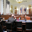

In [30]:
# check real_dataset loader
from PIL import Image
import random
annotations = json.load(open("../data/aggregated/vgr_nocaps_fb_both_complete.json", "r"))
imdir = "/data/yingshac/clevr_control/data/"
a = random.choice(annotations)
print(a[0], a[-1])

im = Image.open(os.path.join(imdir, a[1])).convert("RGB").resize((32, 32))
im

In [7]:
from datasets import load_dataset

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

In [5]:
dataset[0]

{'image_url': 'https://ids.si.edu/ids/deliveryService?id=ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'image_alt': 'view Paper Kite digital asset number 1',
 'id': 'ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'name': 'Paper Kite',
 'scientific_name': 'Idea leuconoe',
 'gender': None,
 'taxonomy': 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae',
 'region': 'US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)',
 'locality': 'NMNH Butterfly Pavilion, North America, United States, District of Columbia',
 'date': None,
 'usnm_no': 'EO401041',
 'guid': 'http://n2t.net/ark:/65665/35f90bc1d-2e3c-4798-a33c-611d7b358636',
 'edan_url': 'edanmdm:nmnheducation_11038234',
 'source': 'Smithsonian Education and Outreach collections',
 'stage': None,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283>,
 'image_hash': 'fb0b8749d437efc70a26e54212b3572c',
 'sim_score': 0.8055200576782227}

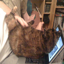

In [13]:
from PIL import Image
im = Image.open("/data/yingshac/clevr_control/data/vl_models_are_bows/images/2326912.jpg").resize((64, 64))
im